# Remapping analysis

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiment import Experiment
from utils import print_stats
from itertools import product
from scipy.stats import pearsonr
from tqdm import tqdm
from gc import collect


data_path = "../data"
save_path = "../figs"

In [2]:
class Analysis:
    def __init__(self, exp, immediate_pc=False):
        self.exp = exp
        self.find_active_cells()
        if immediate_pc:
            self.find_place_cells()
    
    def find_active_cells(self):
        self.active_per_env = {env: set(pfs.get_active_cells().cpu().numpy())
                               for env, pfs in self.exp.pfs_per_env.items()}
    
    def find_place_cells(self):
        self.place_cells_per_env = dict()
        for env in self.exp.pfs_per_env.keys():
            self.exp.compile_grid_cells(env)
            self.exp.load_pfs()
            self.place_cells_per_env[env] = set(self.exp.pfs.get_place_cells().cpu().numpy())
    
    def get_remapping(self, env1, env2):
        pc1, pc2 = self.place_cells_per_env[env1], self.place_cells_per_env[env2]
        pairs = np.asarray(list(product(pc1, pc2)))
        pairs = pairs[pairs[:,0] != pairs[:,1]]

        with torch.no_grad():
            d1 = self.exp.pfs_per_env[env1].pairwise_distances(pairs).cpu()
            d2 = self.exp.pfs_per_env[env2].pairwise_distances(pairs).cpu()
            return 1 - max(0, pearsonr(d1, d2).statistic)
    
    def get_turnover(self, env1, env2, all_active=False):
        units = self.active_per_env if all_active else self.place_cells_per_env
        u1, u2 = units[env1], units[env2]
        s = 1 - (len(u1) + len(u2)) / 2 / self.exp.pfs.N
        rmsd = lambda x, y: np.sqrt(((x - y)**2).sum())
        
        alpha_0 = np.asarray([s, 0, 1 - s])
        beta = np.asarray([s**2, 2 * s * (1 - s), (1 - s)**2])
        alpha = np.asarray([self.exp.pfs.N - len(u1.union(u2)),
                            len(u1.union(u2) - u1.intersection(u2)),
                            len(u1.intersection(u2))]) / self.exp.pfs.N
        
        return 1 - (rmsd(alpha, beta) / rmsd(alpha_0, beta))
    
    def place_cell_stats(self, env1=1, env2=2):
        pc1, pc2 = self.place_cells_per_env[env1], self.place_cells_per_env[env2]

        print("Len env1:", len(pc1))
        print("Len env2:", len(pc2))
        print("Intersection:", len(pc1.intersection(pc2)))
        print("Union:", len(pc1.union(pc2)))
        print("env1 - env2:", len(pc1 - pc2))
        print("env2 - env1:", len(pc2 - pc1))
        print("Remapping:", self.get_remapping(env1, env2))
        print("Turnover:", self.get_turnover(env1, env2))

In [3]:
def get_cell_data(exps):
    data = dict()
    for e in tqdm(exps):
        exp = Experiment.load_experiment(data_path, e)
        anl = Analysis(exp, immediate_pc=True)

        env1, env2 = exp.pfs_per_env.keys()
        pc1, pc2 = anl.place_cells_per_env[env1], anl.place_cells_per_env[env2]
        ac1, ac2 = anl.active_per_env[env1], anl.active_per_env[env2]

        data[e] = dict(
            env1_pc_prop=len(pc1) / exp.pfs.N,
            env2_pc_prop=len(pc2) / exp.pfs.N,
            env1_ac_prop=len(ac1) / exp.pfs.N,
            env2_ac_prop=len(ac2) / exp.pfs.N,
            remap=anl.get_remapping(env1, env2),
            turn_pc=anl.get_turnover(env1, env2),
            turn_ac=anl.get_turnover(env1, env2, all_active=True),
            pc1=pc1,
            pc2=pc2,
            ac1=ac1,
            ac2=ac2
        )
    return data


def plot_lines(df, filename=None, linthresh=1e-3, linear=False):
    _, [ax1, ax2] = plt.subplots(2, 1, figsize=(6, 5))

    ax1.plot(df.iloc[-2:,[0, 2]])
    ax1.plot(df.iloc[-2:,[1, 3]], '--')
    ax1.set_prop_cycle(None)
    ax1.semilogx(df.iloc[:-1,[0, 2]])
    ax1.semilogx(df.iloc[:-1,[1, 3]], '--')

    if linear:
        ax1.set_xscale('linear')
    else:
        ax1.set_xscale('symlog', linthresh=linthresh, linscale=0.5, subs=range(2, 10))
    ax1.set_ylabel("Proportion Active", fontsize=12)
    ax1.legend(df.columns[[0, 2, 1, 3]])


    ax2.plot(df.iloc[-2:,4:7])
    ax2.set_prop_cycle(None)
    ax2.semilogx(df.iloc[:-1,4:7])

    if linear:
        ax2.set_xscale('linear')
    else:
        ax2.set_xscale('symlog', linthresh=linthresh, linscale=0.5, subs=range(2, 10))
    ax2.set_xlabel(df.index.name, fontsize=16)
    ax2.set_ylabel("Remapping/Turnover", fontsize=12)
    ax2.legend(df.columns[4:7])

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [4]:
hiddens = [f'hidden{n}' for n in [20, 50, 200, 500]]
hiddens.insert(2, 'baseline')

In [5]:
data = get_cell_data(hiddens)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [14:40<00:00, 176.14s/it]


In [6]:
labels = ["Place Cells (trn)", "Place Cells (unt)",
          "Active Cells (trn)", "Active Cells (unt)",
          "Remapping", "Turnover (PCs)", "Turnover (ACs)"]
cols = list(data['baseline'].keys())[:7]

In [7]:
df = pd.DataFrame(data).T
df = df.rename(index={k: v for k, v in zip(hiddens, [20, 50, 128, 200, 500])})
df.index = df.index.rename('Hidden Layer Size')
df.iloc[:,:7] = df.iloc[:,:7].astype(float).fillna(0)
df = df.rename(columns={c: l for c, l in zip(cols, labels)})

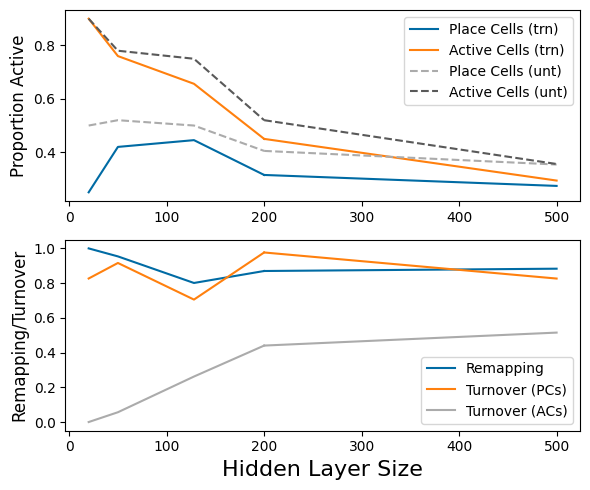

In [8]:
plot_lines(df, linear=True, filename="../figs/remap_hs.png")

In [9]:
l1s = [f'l1_{n}' for n in ['01', '001', '0001', '00001', '000001', '0']]
l1s.insert(2, 'baseline')

In [10]:
data_l1s = get_cell_data(l1s)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [20:15<00:00, 173.66s/it]


In [11]:
df = pd.DataFrame(data_l1s).T
df = df.rename(index={k: v for k, v in zip(l1s, [0.1, 0.01, 0.005, 0.001, 0.0001, 0.00001, 0])})
df.index = df.index.rename('Weight Regularizatin $\\lambda_{l1}$')
df.iloc[:,:7] = df.iloc[:,:7].astype(float).fillna(0)
df = df.rename(columns={c: l for c, l in zip(cols, labels)})
df = df.sort_index(ascending=False)

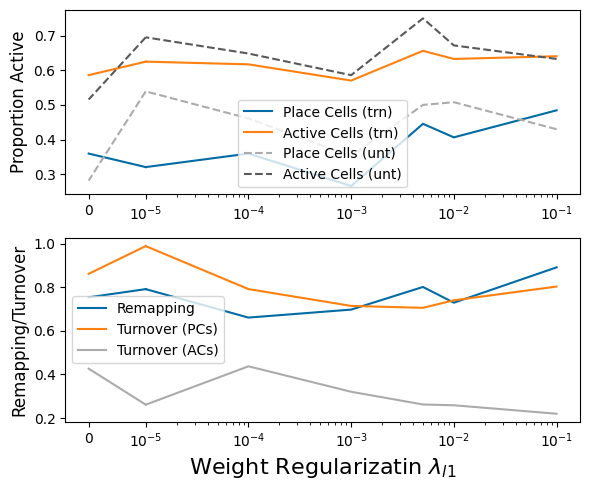

In [12]:
plot_lines(df, linthresh=1e-5, filename="../figs/remap_l1.png")

In [13]:
hps = [f'hp_{n}' for n in ['05', '01', '005', '0005', '0001', '0']]
hps.insert(3, 'baseline')

In [14]:
data_hps = get_cell_data(hps)

 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [17:23<02:54, 174.99s/it]C:\Users\Hackerman\AppData\Local\Temp\ipykernel_5552\2966617882.py:41: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (rmsd(alpha, beta) / rmsd(alpha_0, beta))
100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [20:14<00:00, 173.57s/it]


In [15]:
df = pd.DataFrame(data_hps).T
df = df.rename(index={k: v for k, v in zip(hps, [0.5, 0.1, 0.05, 0.02, 0.005, 0.001, 0])})
df.index = df.index.rename('Hidden Penalty $\\lambda_{hp}$')
df.iloc[:,:7] = df.iloc[:,:7].astype(float).fillna(0)
df = df.rename(columns={c: l for c, l in zip(cols, labels)})

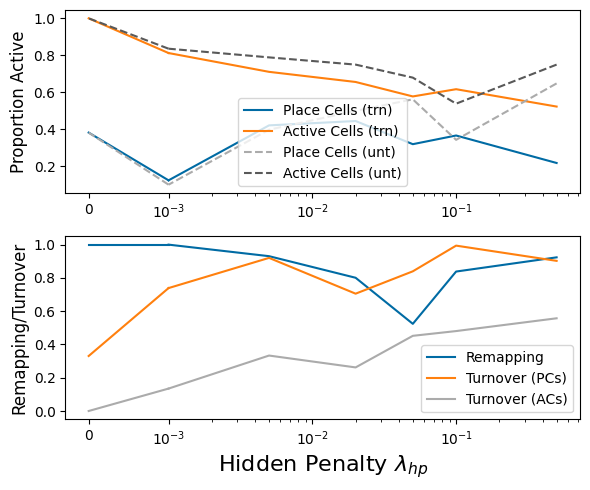

In [16]:
plot_lines(df, filename="../figs/remap_hp.png")